In [ ]:
!nvidia-smi

In [ ]:
!pip install pycocotools

# Image captioning Transformer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import trange, tqdm
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.distributions import Categorical

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision

from torchmetrics.text import BLEUScore

#from torchsummary import summary

import time

import wandb

from transformers import AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.backends.cuda.matmul.allow_tf32 = True

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
data_set_root='data/coco2017'
train_set ='train2017'
validation_set ='val2017'
test_set = 'test2017'

train_image_path = os.path.join(data_set_root, train_set)
train_ann_file = '{}/annotations/captions_{}.json'.format(data_set_root, train_set)

val_image_path = os.path.join(data_set_root, validation_set)
val_ann_file = '{}/annotations/captions_{}.json'.format(data_set_root, validation_set)

test_image_path = os.path.join(data_set_root, test_set)

## parameters 

In [4]:
image_size = 224

batch_size = 64

# Data processing

In [5]:
# Simple transform class to randomly sample one of the five captions
class SampleCaption(nn.Module):
    def __call__(self, sample):
        rand_index = random.randint(0, len(sample) - 1)
        return sample[rand_index]

In [6]:
train_transform = transforms.Compose([transforms.Resize(image_size),
                                      transforms.RandomCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225]),
                                      transforms.RandomErasing(p=0.5)])

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

train_dataset = datasets.CocoCaptions(root=train_image_path,
                                      annFile=train_ann_file,
                                      transform=train_transform,
                                      target_transform=SampleCaption())

val_dataset = datasets.CocoCaptions(root=val_image_path,
                                    annFile=val_ann_file,
                                    transform=transform,
                                    target_transform=SampleCaption())

data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
data_loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=1.33s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [7]:
print(len(data_loader_train))
print(len(data_loader_val))

1849
79


In [8]:
# Create a dataloader itterable object
dataiter = next(iter(data_loader_val))
# Sample from the itterable object
val_images, val_captions = dataiter

A red boat floating in front of a city scape.


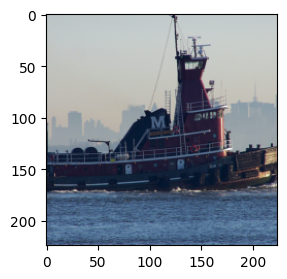

In [9]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(val_images[0:1], 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

caption = val_captions[0]
print(caption)

In [10]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [11]:
tokenizer.vocab_size

30522

In [11]:
tokens = tokenizer(val_captions, padding=True, truncation=True, return_tensors="pt")

In [13]:
tokens['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [14]:
token_ids = tokens['input_ids'][0]
tokens['input_ids']

tensor([[  101,  2630,  9055,  ...,     0,     0,     0],
        [  101,  1037,  2879,  ...,     0,     0,     0],
        [  101,  2048, 16825,  ...,     0,     0,     0],
        ...,
        [  101,  1037,  2158,  ...,  5127,  1012,   102],
        [  101,  2045,  2024,  ...,     0,     0,     0],
        [  101,  1037, 29145,  ...,     0,     0,     0]])

In [15]:
print(tokenizer.decode(token_ids))

[CLS] blue motorcycle parked in small area with wall marked with lots of graffiti. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]


# Pretrain Model 

In [12]:
from transformers import VisionEncoderDecoderModel, AutoModel

# Load models and tokenizer
encoder_model = "google/vit-base-patch16-224-in21k"
decoder_model = "bert-base-uncased"

# Initialize EncoderDecoderModel
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_model, decoder_model
)


Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

In [13]:
# Set decoder config to force the model to attend to encoder outputs
model.config.decoder.is_decoder = True
model.config.decoder.add_cross_attention = True
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 50   # Maximum token length for generated captions
model.config.min_length = 5    # Minimum token length
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4
model.config.attention_dropout = 0.1
model.config.hidden_dropout_prob = 0.1
model.config.gradient_checkpointing = True

# Hyper Parameters

In [14]:
learning_rate = 1e-4

epochs = 70

model_path = 'model/transf_model_pre2.pth'

In [15]:
#model = nn.DataParallel(model, device_ids=[0, 1])
model = model.to(device)

#summary(model, (3, 256, 256))

# Training

## Wandb para

In [ ]:
PROJECT = "Image_Captioning"
RESUME = "allow"
WANDB_KEY = "d9d14819dddd8a35a353b5c0b087e0f60d717140"

## Set up

In [ ]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token.

    Args:
        prob (float): probability of dropping a token
        blank_token (int): index for the blank token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, blank_token=1, eos_token=102):
        super().__init__()
        self.prob = prob
        self.eos_token = eos_token
        self.blank_token = blank_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p=prob
        # to create a mask where 1 means we will replace that token
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()

        # only replace if the token is not the eos token
        can_drop = (~(sample == self.eos_token)).long()
        mask = mask * can_drop

        # Do not replace the sos tokens
        mask[:, 0] = torch.zeros_like(mask[:, 0]).long()

        replace_with = (self.blank_token * torch.ones_like(sample)).long()

        sample_out = (1 - mask) * sample + mask * replace_with

        return sample_out

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scaler = torch.cuda.amp.GradScaler()

loss_fn = nn.CrossEntropyLoss(reduction="none")

td = TokenDrop(0.5)


In [ ]:
wandb.login(
    key = "d9d14819dddd8a35a353b5c0b087e0f60d717140",
)

In [ ]:
wandb.init(
    project=PROJECT,
    resume=RESUME,
    name="init_transformer_pretrain",
    config={
        "learning_rate": learning_rate,
        "epochs": epochs,
        "batch_size": batch_size,
    },
)
wandb.watch(model)

## Train

In [ ]:
# Freeze encoder for initial epochs
freeze_encoder_epochs = 15  # Change this based on your training strategy
freeze_encoder_epochs2 = 30  # Change this based on your training strategy
for param in model.module.encoder.parameters():
    param.requires_grad = False

def unfreeze_encoder_layers(model, num_layers_to_unfreeze):
    """
    Unfreezes the last `num_layers_to_unfreeze` of the encoder.
    """
    encoder_layers = list(model.module.encoder.parameters())

    # Unfreeze the last `num_layers_to_unfreeze` layers
    for param in encoder_layers[-num_layers_to_unfreeze:]:
        param.requires_grad = True


In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1, verbose=True)

In [ ]:
# Early stopping parameters
patience = 15  # Number of epochs to wait for improvement
counter = 0   # Counter to track the number of epochs without improvement
best_val_loss = float('inf')  # Initialize the best validation loss
best_epoch = 0  # Track the epoch when the best model was found
bleu_metric = BLEUScore(n_gram=4, smooth=True).to(device)

def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    
    # Unfreeze encoder after early epochs
    if epoch == freeze_encoder_epochs and not any(p.requires_grad for p in model.module.encoder.parameters()):
        unfreeze_encoder_layers(model, num_layers_to_unfreeze=2)
        print("Unfroze last 2 encoder layers.")

    if epoch == freeze_encoder_epochs2 and not any(p.requires_grad for p in model.module.encoder.parameters()):
        for param in model.module.encoder.parameters():
            param.requires_grad = True
        print("Unfroze all encoder layers.")
    
    # Training process here

    running_loss = 0.0
    # Iterate over the training data loader
    for images, captions in tqdm(data_loader_train, desc="Training", leave=False):
        images = images.to(device)
        tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt").to(device)
        token_ids = tokens['input_ids']
        padding_mask = tokens['attention_mask']

        # Shift right the input sequence to create the target sequence
        b = token_ids.shape[0]
        labels = torch.cat((token_ids[:, 1:], torch.zeros(b, 1, device=device).long()), 1).to(device)
        
        # Ignore padding tokens in loss calculation
        labels[token_ids == tokenizer.pad_token_id] = -100

        tokens_in = td(token_ids)

        # Forward pass
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(
                pixel_values=images, 
                decoder_input_ids=tokens_in, 
                decoder_attention_mask=padding_mask, 
                labels=labels
            )    
            loss = outputs.loss.mean()
            
        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    epoch_loss = running_loss / len(data_loader_train)
    
    return epoch_loss

def validate_epoch(model, dataloader, loss_fn, device):
    model.eval()
    total_val_loss = 0
    bleu_metric.reset()  # Reset BLEU metric before validation

    with torch.no_grad():
        for images, captions in tqdm(dataloader, desc="Validation", leave=False):
            images = images.to(device)
            tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
            token_ids = tokens['input_ids'].to(device)
            padding_mask = tokens['attention_mask'].to(device)
            
            # Shift right the input sequence to create the target sequence
            b = token_ids.shape[0]
            labels = torch.cat((token_ids[:, 1:], torch.zeros(b, 1, device=device).long()), 1).to(device)
            
            # Ignore padding tokens in loss calculation
            labels[token_ids == tokenizer.pad_token_id] = -100

            tokens_in = td(token_ids)

            outputs = model(
                pixel_values=images,
                decoder_input_ids=tokens_in,
                decoder_attention_mask=padding_mask, 
                labels=labels
            )
            val_loss = outputs.loss.mean()    
            total_val_loss += val_loss.item()

            # Decode predictions and targets
            pred_ids = outputs.logits.argmax(dim=-1)
            pred_texts = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
            target_texts = tokenizer.batch_decode(token_ids, skip_special_tokens=True)


            # Update BLEU score
            bleu_metric.update(pred_texts, target_texts)

    epoch_loss = total_val_loss / len(dataloader)
    avg_bleu_score = bleu_metric.compute()

    return [epoch_loss, avg_bleu_score]


for epoch in trange(0, epochs, leave=False, desc="Epoch"):
    start_time = time.time()

    train_loss = train_epoch(model, data_loader_train, optimizer, loss_fn, device)
    val_loss, val_bleu = validate_epoch(model, data_loader_val, loss_fn, device)

    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Bleu_Score: {val_bleu:.4f}, Learning Rate: {current_lr:.8f}")

    # Check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        counter = 0  # Reset counter if loss improved
        torch.save(model.state_dict(), model_path)
        #model.save_pretrained(model_path)

        print(f"New best checkpoint saved with val_loss: {val_loss:.4f}")
    else:
        counter += 1
        print(f"Validation loss did not improve. Counter: {counter}/{patience}")

    # Early stopping: stop training if no improvement after 'patience' epochs
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Validation loss did not improve for {patience} epochs.")
        break

    # Log results to WandB
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "Bleu_Score": val_bleu,
        "learning_rate": current_lr,
    })

wandb.finish()

# Test

In [43]:
state_dict = torch.load(model_path)
from collections import OrderedDict

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "")  # remove 'module.' prefix
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model = model.to(device)

C:\Users\MY LAPTOP\AppData\Local\Temp\ipykernel_24300\3989904523.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


In [44]:
model.load_state_dict(new_state_dict)
model = model.to(device)

In [117]:
# Create a dataloader itterable object
dataiter = next(iter(data_loader_val))
# Sample from the itterable object
val_images, val_captions = dataiter

In [118]:
# Choose an index within the batch
index = 0
val_images = val_images[index].unsqueeze(0)

A man is at a wine tasting event taking notes on a computer.


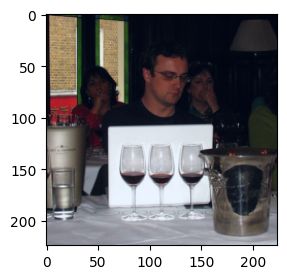

In [119]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(val_images, 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))
print(val_captions[index])

In [120]:
val_images = val_images.to(torch.float).to(device)

In [121]:
#log_tokens = [sos_token]
model.eval().to(device)


with torch.no_grad():
    # Encode the input image
    with torch.cuda.amp.autocast():
        generated_ids = model.generate(
                                        val_images, 
                                        max_length=50, 
                                        num_beams=4, 
                                        early_stopping=True
                                    )
        caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

C:\Users\MY LAPTOP\AppData\Local\Temp\ipykernel_24300\4148883403.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


In [122]:
#print("Generated IDs:", generated_ids)
print(caption)

a group of people sitting at a table with wine glasses.


In [54]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(val_images, 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

<Figure size 300x300 with 0 Axes>